# YOLO-KP SDNN Example

This tutorial demonstrates the inference of YOLO-KP SDNN (training example scripts [here](https://github.com/lava-nc/lava-dl/tree/main/tutorials/lava/lib/dl/slayer/tiny_yolo_sdnn)) on both CPU and Loihi 2 neurocore.

![image](https://github.com/lava-nc/lava/assets/29907126/61057e64-71b3-4ab8-a7ea-39d0cdbac70d)

YOLO-KP is a fully convolutional single-headed variant of TinyYOLOv3 object detection architecture specifically designed for 8 chip Loihi 2 form factor called Kapoho Point (KP). The inference example uses the following lava components

1. __Network on Loihi 2:__ YOLO-KP network generated from its NetX description. It is a hierarchical network consisting of all the layers of YOLO-KP. This is the portion that runs on Loihi.
2. __Data sparsification on SuperHost:__ Delta encoder process that performs frame difference to sparsify the input being communicated to the YOLO-KP network. This process runs on Python.
3. __Data communication in and out of lava processes:__ `Injector` process to send raw input to the lava network and `Extractor` process to receive raw output of YOLO-KP. These processes run on Python.
4. __Data relay in and out of Loihi chip:__ Input and output adapter process which relay the communication into the chip and out of the chip. Since YOLO-KP is fully convolutional, the adapters translate to/from python spike and Loihi convolution spike.

> ℹ️ This example currently does not make use of high speed IO capabilities of Loihi and hence the execution is slow. Once the software support is enabled in Lava, these adapters will not be required and shall be removed.

In [1]:
import os
import yaml
import logging

import numpy as np
import matplotlib.pyplot as plt

from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg, Loihi2SimCfg
from lava.proc import io

from lava.lib.dl import netx
from lava.lib.dl import slayer
from lava.lib.dl.slayer import obd

from utils import DataGenerator, YOLOPredictor, nms, YOLOMonitor, DeltaEncoder
from jupyter_utils import Display
from IPython.display import Markdown

# Import modules for Loihi2 execution

Check if Loihi2 compiler is available and import related modules.

---
> ⚠️**NOTE:** Running with 10G ethernet currently requires elevated networking privileges. The script for it is located at `<frameworks.ai.lava.lava-loihi path>/utils/cap_net_raw`
> 
> * To run a python script, use
>   
>   `<frameworks.ai.lava.lava-loihi path>/utils/cap_net_raw python <script>.py`
> * To launch a jupyter session, use
>
>   `nohup <frameworks.ai.lava.lava-loihi path>/utils/cap_net_raw jupyter lab --no-browser &`
---

In [2]:
loihi2_is_available = True

if loihi2_is_available:
    # The following is a no-SLURM environment variable setting
    os.environ["LOIHI_GEN"] = "N3C1"
    os.environ["NXSDKHOST"] = "ncl-gdc-vpx-01.zpn.intel.com"  # this needs to be changed for user specific system
    os.environ["NXOPTIONS"] = "--pio-cfg-chip=0x41FF"         # this is board specific, most relaxed config is 0x41FF
    
    # # The folliwng is a SLURM environment variable setting example
    # os.environ["SLURM"] = "1"
    # os.environ["LOIHI_GEN"] = "N3C1"
    # os.environ["BOARD"] = "ncl-og-01"                         # this needs to be changed for user specific system
    # os.environ["NXOPTIONS"] = "--pio-cfg-chip=0x41FF"         # this is board specific, most relaxed config is 0x41FF
    
    from lava.magma.compiler.subcompilers.nc.ncproc_compiler import CompilerOptions
    CompilerOptions.verbose = True
else:
    print("Loihi2 compiler is not available in this system. "
          "This tutorial will execute on CPU backend.")

## Set execution parameters

The network execution parameters can be divided into three categories:

1. __Model parameters:__ these are parameters of the YOLO model used for the training and shall be reused to replicate the same behavior during inference.
2. __Inference parametrs:__ these are parameters just for the inference.
3. __Data processing parameters:__ these are parameters need to perform _pre_ and _post_ processing before the input and on the output of the network respectively.

In [3]:
# Model arguments
trained_folder = os.path.abspath('../../slayer/tiny_yolo_sdnn/Trained_yolo_kp')
with open(trained_folder + '/args.txt', 'rt') as f:
    model_args = slayer.utils.dotdict(yaml.safe_load(f))

# Additional inference arguments
inference_args = slayer.utils.dotdict(loihi=loihi2_is_available,
                                      spike_exp=4,    # This sets the decimal/fraction precision of spike message to 4 bits
                                      num_steps=100)  # Number of frames to perform inference on

# Pre and post processing parameters
pre_args = slayer.utils.dotdict(input_mean=np.array([0.485, 0.456, 0.406]),  # Input normalization mean
                                input_std=np.array([0.229, 0.224, 0.225]))   #                     & std
post_args = slayer.utils.dotdict(anchors=np.array([(0.28, 0.22),  # YOLO head's anchor preset scales
                                                   (0.38, 0.48),
                                                   (0.90, 0.78)]))

## Load YOLO-KP network

Loading the network is a simple NetX call on the trained model computational graph. It will generate an hierarchical lava process representing the entire YOLO-KP network.

In [4]:
net = netx.hdf5.Network(trained_folder + '/network.net',
                        skip_layers=1,  # First layer does delta encoding. We will only send it's sparsified output
                        input_message_bits=16,  # This means the network takes 16bit graded spike input
                        spike_exp=inference_args.spike_exp)
print(f'The model was trained for {model_args.dataset} dataset')
print(f'\nNetwork Architecture ({model_args.model}):'); print('=' * (24 + len(model_args.model))); print(net)

The model was trained for BDD100K dataset

Network Architecture (yolo_kp):
|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Conv      |  224|  224|   16| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |  112|  112|   32| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |   56|   56|   64| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |   28|   28|  128| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |   28|   28|  256| 3, 3| 1, 1| 1, 1| 1, 1|    1|False|
|Conv      |   14|   14|  256| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |   14|   14|  512| 3, 3| 1, 1| 1, 1| 1, 1|    1|False|
|Conv      |   14|   14|  256| 1, 1| 1, 1| 0, 0| 1, 1|    1|False|
|Conv      |   14|   14|  512| 3, 3| 1, 1| 1, 1| 1, 1|    1|False|
|Conv      |   14|   14|   48| 1, 1| 1, 1| 0, 0| 1, 1|    1|False|


## Dataset and input source

The dataset is the same module that is used for training. It is wrapped around by a data generator module that will generate an individual frame and its annotation at every time-step. The data generator also takes care of data normalization using the mean and variance supplied.

In [5]:
test_set = obd.dataset.BDD(root=model_args.path, dataset='track',
                           train=False, randomize_seq=False,
                           seq_len=inference_args.num_steps)
test_set.datasets[0].ids = sorted(test_set.datasets[0].ids) # for determinism
data_gen = DataGenerator(dataset=test_set, mean=pre_args.input_mean, std=pre_args.input_std)

## Input preprocessing and encoding

The input preprocessing involves quantization of the numeric data making it ready to be processed on the chip. A fractional representation of 6 bits was used in the weight of the network during training (`weight_exp`) which is also accounted for during quantization.

The quantized input frames are then processed the the lava processes `sender`, `encoder` (and `inp_adapter` for Loihi execution) which will be connected in a sequential manner below.

In [6]:
quantize = netx.modules.Quantize(exp=6)  # convert to fixed point representation with 6 bit of fraction
sender = io.injector.Injector(shape=net.inp.shape, buffer_size=128)
encoder = DeltaEncoder(vth=net.net_config['layer'][0]['neuron']['vThMant'],
                       spike_exp=net.spike_exp,
                       num_bits=8)

## Output decoding and post processing

The output of YOLO-KP goes through (`state_adapter` for Loihi execution), `receiver` and `dequantizer` lava processes which will be connected sequentially. The raw outputs needs to be processed using `yolo_predictor` which transforms the input to the actual bounding box predictions of the network.

In [7]:
receiver = io.extractor.Extractor(shape=net.out.shape, buffer_size=128)
dequantize = netx.modules.Dequantize(exp=net.spike_exp + 12, num_raw_bits=24)
yolo_predictor = YOLOPredictor(anchors=post_args.anchors, clamp_max=model_args.clamp_max)

## Output visualization

`YOLOMonitor` is a flexible output visualization and evaluation module. It continuously evaluates the mAP score of the output predictions. It can also be passed a callable function that can be used to display. In this case it is a basic iPython display routine.

In [8]:
display = Display(default_size=(448 * 2, 448))

def output_visualizer(annotated_frame, map_score, frame_idx):
    display.push(frame=annotated_frame,
                 msg=f'Processed frame `{frame_idx}`\nObject detection mAP@0.5: `{map_score:.2f}`')
    
yolo_monitor = YOLOMonitor(viz_fx=output_visualizer, class_list=test_set.classes)

## Data buffers / delays

There is a latency in the prediction equal to the number of layers the network has and the encoding step. Two FIFO buffers are used to synchronize the input frame and target annotation with the predicted output.

In [9]:
frame_buffer = netx.modules.FIFO(depth=len(net))
annotation_buffer = netx.modules.FIFO(depth=len(net))

# Connect Lava processes

In [10]:
if inference_args.loihi:
    # The following are configurations specific to 10G ethernet connection
    from lava.magma.core.process.ports.connection_config import ConnectionConfig, SpikeIOInterface, SpikeIOMode
    connection_config = ConnectionConfig()
    connection_config.interface = SpikeIOInterface.ETHERNET
    connection_config.spike_io_mode = SpikeIOMode.FREE_RUNNING
    connection_config.ethernet_chip_id = (2, 2, 1)             # same for VPX16 boards
    connection_config.ethernet_chip_idx = 12                   # same for VPX16 boards
    connection_config.ethernet_mac_address = "0x80615f11b9d6"  # MAC address needs to be the address of 10G NIC in super host

    # # Eventual API will be the following, but it does not currently work.
    # sender.out_port.connect(net.inp)
    # net.out.connect(receiver.in_port)
    sender.out_port.connect(net.in_layer.synapse.s_in, connection_config)
    net.out_layer.neuron.s_out.connect(receiver.in_port, connection_config)
else:
    sender.out_port.connect(net.inp)
    net.out.connect(receiver.in_port)

# Setup execution

The network is run in _non-blocking mode_. Note the `blocking=False` argument below. In non-blocking mode we can start running the lava process and do other computations in parallel. Here we will preprocess the data, send it to lava network using `sender` (`lava.proc.io.injector.Injector` instance), receive data from lava using `receiver` (`lava.proc.io.extractor.Extractor` instance), and perform additional processing, while the Lava network is running in parallel.

In [11]:
num_steps = inference_args.num_steps
run_condition = RunSteps(num_steps=num_steps, blocking=False)

from lava.magma.core.model.py.model import PyLoihiModelToPyAsyncModel

# Async processes for fastest possible execution
exception_proc_model_map = {io.encoder.DeltaEncoder: PyLoihiModelToPyAsyncModel(io.encoder.PyDeltaEncoderModelDense),
                            io.injector.Injector: io.injector.PyLoihiInjectorModelAsync,
                            io.extractor.Extractor: io.extractor.PyLoihiExtractorModelAsync,}

if inference_args.loihi:
    run_config = Loihi2HwCfg(exception_proc_model_map=exception_proc_model_map)
else:
    run_config = Loihi2SimCfg(select_tag='fixed_pt',
                              exception_proc_model_map=exception_proc_model_map)

# Run YOLO-KP inference

The following will compile and run the Lava network.

> ℹ️ The network is large. It will take a while for the compilation to finish.

In [12]:
sender._log_config.level = logging.INFO
sender.run(condition=run_condition, run_cfg=run_config)

Partitioning converged after iteration=3
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.01%|  25.00%|  65.64%|  19.20%|  16.80%|   0.00%|  42.26%|       4|Conv(4, 14, 48)
|   0.01%|  12.50%|  87.52%|  86.40%|   0.35%|   0.17%|  87.47%|      32|Conv(8, 7, 64)
|   0.01%|  12.50%|  87.52%|  67.20%|   0.09%|   0.35%|  72.04%|      14|Conv(2, 7, 256)
|   0.01%|  12.50%|  87.52%|  86.40%|   0.35%|   0.35%|  87.61%|      32|Conv(8, 7, 64)
|   0.01%|  12.50%|  87.52%|  72.00%|   0.35%|   2.80%|  78.05%|      16|Conv(8, 7, 64)
|   0.01%|  12.50%|  87.52%|  79.20%|   0.17%|   0.17%|  81.57%|      56|Conv(4, 7, 128)
|   0.01%|  12.50%|  87.52%|  39.60%|   0.17%|   0.35%|  50.03%|      28|Conv(4, 7, 128)
|   0.01%|  12.50%|  87.52%|  10.80%|   0.35%|   0.17%|  26.99%|      56|Conv(4, 14, 64)
|   0.

/home/sshresth/lava-vpx/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


INFO:DRV:  Running in non-slurm environment on : ncl-gdc-vpx-01.zpn.intel.com
INFO:HST:  Initializing PAC193X registers to defaults.
INFO:DRV:  Connecting to ncl-gdc-vpx-01.zpn.intel.com:40573
INFO:DRV:      Host server up..............Done 5.36s
INFO:DRV:      Mapping chipIds.............Done 0.06ms
INFO:DRV:      Mapping coreIds.............Done 5.90ms
INFO:DRV:      Partitioning neuron groups..Done 0.16s
INFO:DRV:      Mapping axons...............Done 0.51s
INFO:DRV:      Configuring Spike Block.....Done 0.17ms
INFO:DRV:      Writes SpikeIO Config to FileDone 5.88ms
INFO:DRV:      Initializes Python MQ.......Done 0.78s
INFO:DRV:      Partitioning MPDS...........Done 0.13s
INFO:DRV:      Compiling Embedded snips....Done 4.82s
INFO:DRV:      Compiling Host snips........Done 0.08ms
INFO:DRV:      Compiling Register Probes...Done 0.10ms
INFO:DRV:      Compiling Spike Probes......Done 0.01ms
INFO:HST:  Args chip=0 cpu=0 /home/sshresth/lava-vpx/frameworks.ai.nx.nxsdk/nxcore/arch/base/pre_

In [13]:
import threading
import queue

def sender_thread(sender, send_frame_queue, num_steps):
    # This is a dedicated routine to send data to the network as fast as possible
    for _ in range(num_steps):
        frame = send_frame_queue.get()
        sender.send(frame)        # This sends the input frame to the Lava network

def receiver_thread(receiver, recv_frame_queue, num_steps):
    # This is a dedicated routine to receive data from the network as fast as possible
    for t in range(num_steps):
        out = receiver.receive()  # This receives the output from the Lava network
        out = dequantize(out)
        
        annotation, raw_frame = recv_frame_queue.get()
        input_frame = frame_buffer(raw_frame)
        gt_ann = annotation_buffer(annotation)
        if input_frame is not None:  # valid output from FIFO buffer
            predictions = yolo_predictor(out)
            pred_bbox = nms(predictions)
            gt_bbox = obd.bbox.utils.tensor_from_annotation(gt_ann).cpu().data.numpy()
            yolo_monitor(input_frame, gt_bbox, pred_bbox)
        else:
            print(f'Frame {t} queued in pipeline.', end='\r')

s_q = queue.Queue()
r_q = queue.Queue()
s_th = threading.Thread(target=sender_thread, args=(sender, s_q, num_steps))
r_th = threading.Thread(target=receiver_thread, args=(receiver, r_q, num_steps))

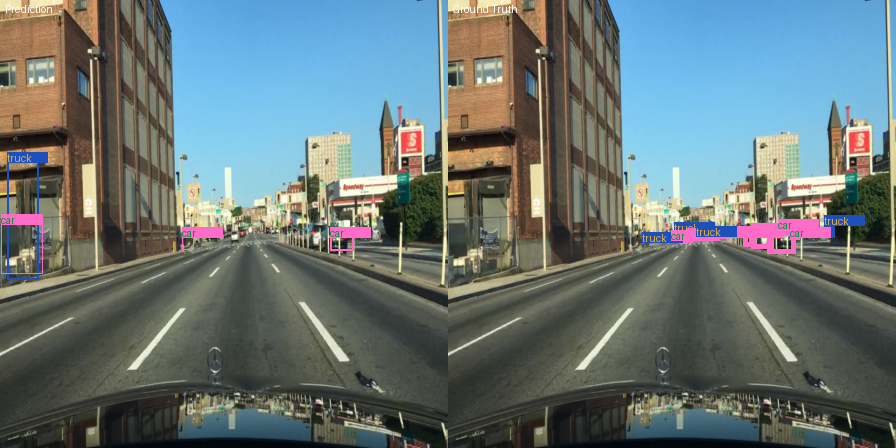

Processed frame `90`<br>Object detection mAP@0.5: `0.28`

End of Ethernet Snooper Program


In [14]:
s_th.start()
r_th.start()
display.start()

for t in range(num_steps):
    frame, annotation, raw_frame = data_gen()
    frame = quantize(frame)
    frame = encoder(frame)
    
    s_q.put(frame)
    r_q.put((annotation, raw_frame))

s_th.join()
r_th.join()
display.stop()

sender.wait()
sender.stop()